# Import Libraries

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib as plt

import pickle

In [2]:
df = pd.read_excel('Telco_customer_churn_adapted_v2.xlsx')

In [3]:
df.head(5).style.background_gradient()

,Customer ID,Tenure Months,Location,Device Class,Games Product,Music Product,Education Product,Call Center,Video Product,Use MyApp,Payment Method,Monthly Purchase (Thou. IDR),Churn Label,Longitude,Latitude,CLTV (Predicted Thou. IDR)
0,0,2,Jakarta,Mid End,Yes,Yes,No,No,No,No,Digital Wallet,70.005000,Yes,106.816666,-6.200000,4210.700000
1,1,2,Jakarta,High End,No,No,No,No,No,No,Pulsa,91.910000,Yes,106.816666,-6.200000,3511.300000
2,2,8,Jakarta,High End,No,No,Yes,No,Yes,Yes,Pulsa,129.545000,Yes,106.816666,-6.200000,6983.600000
3,3,28,Jakarta,High End,No,No,Yes,Yes,Yes,Yes,Pulsa,136.240000,Yes,106.816666,-6.200000,6503.900000
4,4,49,Jakarta,High End,No,Yes,Yes,No,Yes,Yes,Debit,134.810000,Yes,106.816666,-6.200000,6942.000000


In [4]:
df['Games Product'].value_counts()

No                     3498
Yes                    2019
No internet service    1526
Name: Games Product, dtype: int64

# Preprocessed

## Feature Engineering

### Create Segment using CLTV

#### Using Qcut

In [5]:
#df['Customer Value'] = pd.qcut(df['CLTV (Predicted Thou. IDR)'], 3, labels=['Low-Value', 'Mid-Value', 'High-Value'])

In [6]:
#df['Customer Value'] = df['Customer Value'].astype(object)

#### Using Percentile

In [7]:
# Calculate CLV Percentiles
percentiles = df['CLTV (Predicted Thou. IDR)'].quantile([0.25, 0.5, 0.75])
print(percentiles)
# Define thresholds
low_threshold = percentiles[0.25]
mid_threshold = percentiles[0.5]
high_threshold = percentiles[0.75]

0.25    4509.70
0.50    5885.10
0.75    6994.65
Name: CLTV (Predicted Thou. IDR), dtype: float64


In [8]:
# Categorize customers
def categorize_customer(clv):
    if clv <= low_threshold:
        return 'Low-Value'
    elif clv <= mid_threshold:
        return 'Mid-Value'
    else:
        return 'High-Value'

In [9]:
# Apply categorization to the DataFrame
df['Customer Value'] = df['CLTV (Predicted Thou. IDR)'].apply(categorize_customer)

In [10]:
df['Customer Value'].value_counts(normalize=True)*100

High-Value    49.992901
Low-Value     25.031947
Mid-Value     24.975153
Name: Customer Value, dtype: float64

### Create Num Product Used

In [11]:
df['Num Product Used'] = (df[['Games Product', 'Music Product', 'Education Product', 'Video Product']]
                        .replace({'Yes': 1, 'No': 0, 'No internet service': 0}).sum(axis=1))

## Feature Transformation

- Products from Yes, No, No Internet Service to only Yes and No

In [12]:
df['Internet Access'] = df['Games Product'].replace({'No': 'Yes', 'No internet service': 'No'})

df['Games Product'].replace({'No internet service': 'No'}, inplace=True)
df['Music Product'].replace({'No internet service': 'No'}, inplace=True)
df['Education Product'].replace({'No internet service': 'No'}, inplace=True)
df['Video Product'].replace({'No internet service': 'No'}, inplace=True)
df['Use MyApp'].replace({'No internet service': 'No'}, inplace=True)

In [13]:
df['Games Product'].value_counts()

No     5024
Yes    2019
Name: Games Product, dtype: int64

### Encoding

In [14]:
model_cols = ['Tenure Months', 'CLTV (Predicted Thou. IDR)', 'Num Product Used',
       'Device Class', 'Payment Method', 'Churn Label', 'Music Product', 'Video Product',
       'Use MyApp', 'Games Product', 'Call Center']

In [15]:
df[model_cols].head(5)

,Tenure Months,CLTV (Predicted Thou. IDR),Num Product Used,Device Class,Payment Method,Churn Label,Music Product,Video Product,Use MyApp,Games Product,Call Center
0,2,4210.7,2,Mid End,Digital Wallet,Yes,Yes,No,No,Yes,No
1,2,3511.3,0,High End,Pulsa,Yes,No,No,No,No,No
2,8,6983.6,2,High End,Pulsa,Yes,No,Yes,Yes,No,No
3,28,6503.9,2,High End,Pulsa,Yes,No,Yes,Yes,No,Yes
4,49,6942.0,3,High End,Debit,Yes,Yes,Yes,Yes,No,No


In [16]:
model_cat_cols = list(df[model_cols].select_dtypes(include='object').columns)
model_cat_cols

['Device Class',
 'Payment Method',
 'Churn Label',
 'Music Product',
 'Video Product',
 'Use MyApp',
 'Games Product',
 'Call Center']

In [17]:
model_num_cols = list(df[model_cols].select_dtypes(exclude='object').columns)
model_num_cols

['Tenure Months', 'CLTV (Predicted Thou. IDR)', 'Num Product Used']

In [18]:
# Ordinal Encoding
categorical_encoded_ord = (df['Device Class'].map({'Low End': 0,
                                                  'Mid End': 1,
                                                  'High End': 2}))
# One Hot Encoding
sub_cat_cols = list(set(model_cat_cols)-set(['Device Class', 'Churn Label', 'Music Product',
                                             'Video Product', 'Use MyApp', 'Games Product',
                                             'Call Center']))
categorical_encoded_nom = pd.get_dummies(df[sub_cat_cols], drop_first=True)

binary_cols = ['Churn Label', 'Games Product', 'Video Product', 
                  'Music Product', 'Use MyApp', 'Call Center']

binary_encoded = df[binary_cols].replace({'Yes': 1, 'No': 0, 'No internet service': 0})

In [19]:
df_final = pd.concat([df[model_num_cols], categorical_encoded_ord, categorical_encoded_nom, binary_encoded], axis=1)
df_final.columns

Index(['Tenure Months', 'CLTV (Predicted Thou. IDR)', 'Num Product Used',
       'Device Class', 'Payment Method_Debit', 'Payment Method_Digital Wallet',
       'Payment Method_Pulsa', 'Churn Label', 'Games Product', 'Video Product',
       'Music Product', 'Use MyApp', 'Call Center'],
      dtype='object')

## Model Prediction

In [20]:
X = df_final.drop(columns=['Churn Label'], axis=1)
y= df_final['Churn Label']

### Scaling

In [21]:
# Read Scaler
path = './output'
with open(path+'/scaler.pickle', 'rb') as file:
    scaler = pickle.load(file)

In [22]:
X_column_order = ['Tenure Months', 'CLTV (Predicted Thou. IDR)', 'Num Product Used',
       'Device Class', 'Payment Method_Debit', 'Payment Method_Digital Wallet',
       'Payment Method_Pulsa', 'Music Product', 'Video Product', 'Use MyApp',
       'Games Product', 'Call Center']

X_ordered = X[X_column_order]
X_ordered.columns

Index(['Tenure Months', 'CLTV (Predicted Thou. IDR)', 'Num Product Used',
       'Device Class', 'Payment Method_Debit', 'Payment Method_Digital Wallet',
       'Payment Method_Pulsa', 'Music Product', 'Video Product', 'Use MyApp',
       'Games Product', 'Call Center'],
      dtype='object')

In [23]:
X_scaled = scaler.transform(X_ordered)

### Load Model

In [24]:
# Read Scaler
path = './saved_model'
with open(path+'/lgr_final_model.pickle', 'rb') as file:
    lgr = pickle.load(file)

In [25]:
df['Churn Probability'] = lgr.predict_proba(X_scaled)[:, 1]

In [26]:
df['Churn Predicted'] = lgr.predict(X_scaled)

In [27]:
df[['Churn Label', 'Churn Predicted', 'Churn Probability']]

,Churn Label,Churn Predicted,Churn Probability
0,Yes,0,0.424499
1,Yes,1,0.879698
2,Yes,1,0.902525
3,Yes,1,0.748442
4,Yes,1,0.521316
...,...,...,...
7038,No,0,0.042538
7039,No,0,0.296218
7040,No,0,0.320128
7041,No,1,0.524161


In [28]:
df['Churn Probability'].describe()

count    7043.000000
mean        0.425357
std         0.271788
min         0.034899
25%         0.184122
50%         0.364874
75%         0.668660
max         0.929290
Name: Churn Probability, dtype: float64

In [29]:
df[['Churn Label', 'Churn Predicted', 'Churn Probability']].sample(1000)

,Churn Label,Churn Predicted,Churn Probability
2779,No,0,0.363980
3006,No,0,0.042764
6347,No,0,0.407205
4275,No,0,0.190477
4403,No,0,0.290791
...,...,...,...
4180,No,0,0.049532
3925,No,1,0.738467
2554,No,1,0.654975
4417,No,0,0.315353


In [30]:
df['Churn Predicted'].value_counts(normalize=True)

0    0.613801
1    0.386199
Name: Churn Predicted, dtype: float64

In [31]:
 pd.crosstab(df['Churn Label'], df['Churn Predicted'])

Churn Predicted,0,1
Churn Label,,
No,3880,1294
Yes,443,1426


In [32]:
 pd.crosstab(df['Churn Label'], df['Customer Value'])

Customer Value,High-Value,Low-Value,Mid-Value
Churn Label,,,
No,2731,1156,1287
Yes,790,607,472


## Risk Assessment

### Using Qcut

In [33]:
pd.qcut(df['Churn Probability'], 3).value_counts()

(0.0339, 0.249]    2348
(0.566, 0.929]     2348
(0.249, 0.566]     2347
Name: Churn Probability, dtype: int64

### Using Percentile

In [34]:
# Calculate CLV Percentiles
percentiles = df['Churn Probability'].quantile([0.25, 0.5, 0.75])
print(percentiles)
#Define thresholds
low_threshold = percentiles[0.25]
mid_threshold = percentiles[0.5]
high_threshold = percentiles[0.75]

0.25    0.184122
0.50    0.364874
0.75    0.668660
Name: Churn Probability, dtype: float64


In [35]:
low_threshold = 0.30
mid_threshold = 0.70
high_threshold = 1.00

In [36]:
def categorize_customer_risk(probability):
    if probability <= low_threshold:
        return 'Low-Risk'
    elif probability <= mid_threshold:
        return 'Mid-Risk'
    else:
        return 'High-Risk'

In [37]:
# Apply categorization to the DataFrame
df['Customer Risk'] = df['Churn Probability'].apply(categorize_customer_risk)

In [38]:
df['Customer Risk'].value_counts()

Low-Risk     2809
Mid-Risk     2637
High-Risk    1597
Name: Customer Risk, dtype: int64

In [39]:
#df.to_csv('')

#### Analyze Count

In [40]:
pd.crosstab(df['Customer Value'], df['Customer Risk']).style.background_gradient()

Customer Risk,High-Risk,Low-Risk,Mid-Risk
Customer Value,,,
High-Value,602,1697,1222
Low-Value,572,432,759
Mid-Value,423,680,656


In [41]:
pd.crosstab(df['Customer Value'], df['Customer Risk'], normalize='all').style.background_gradient()

Customer Risk,High-Risk,Low-Risk,Mid-Risk
Customer Value,,,
High-Value,0.085475,0.240948,0.173506
Low-Value,0.081215,0.061337,0.107767
Mid-Value,0.060060,0.096550,0.093142


In [42]:
pd.crosstab(df['Customer Value'], df['Customer Risk'], normalize='index').style.background_gradient()

Customer Risk,High-Risk,Low-Risk,Mid-Risk
Customer Value,,,
High-Value,0.170974,0.481965,0.347060
Low-Value,0.324447,0.245037,0.430516
Mid-Value,0.240478,0.386583,0.372939


In [43]:
pd.crosstab(df['Customer Value'], df['Customer Risk'], normalize='columns').style.background_gradient()

Customer Risk,High-Risk,Low-Risk,Mid-Risk
Customer Value,,,
High-Value,0.376957,0.604130,0.463405
Low-Value,0.358172,0.153791,0.287827
Mid-Value,0.264872,0.242079,0.248768


In [44]:
pd.crosstab(df['Customer Risk'], df['Churn Label'], normalize='all').style.background_gradient()

Churn Label,No,Yes
Customer Risk,,
High-Risk,0.081641,0.145109
Low-Risk,0.378674,0.020162
Mid-Risk,0.274315,0.100099


In [45]:
df.to_csv('Telco_Customer_ValueandRisk_Segmented_Final1.csv', index=False)

In [46]:
#test = pd.read_csv('Telco_Customer_ValueandRisk_Segmented_Final1.csv')

In [47]:
df['Churn Predicted'].value_counts(normalize=True)*100

0    61.380094
1    38.619906
Name: Churn Predicted, dtype: float64

In [48]:
df['Churn Label'].value_counts(normalize=True)*100

No     73.463013
Yes    26.536987
Name: Churn Label, dtype: float64

## Decision Threshold (probs >= 0.65)

In [49]:
from sklearn.metrics import PrecisionRecallDisplay, f1_score, precision_recall_curve, precision_score, recall_score

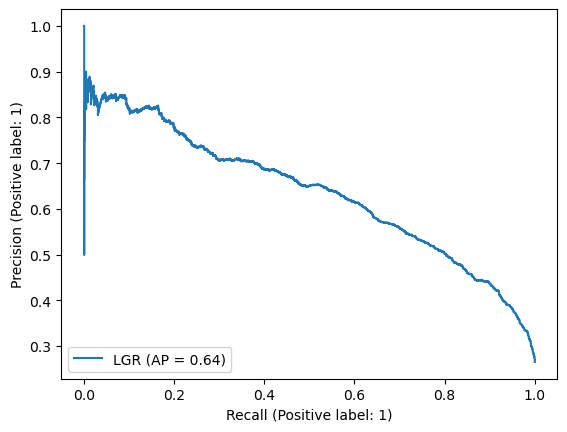

In [50]:
display = PrecisionRecallDisplay.from_estimator(lgr, X_scaled, y, name='LGR')

In [51]:
# Assuming you have already computed precision_recall_curve
precision, recall, thresholds = precision_recall_curve(df['Churn Label'].replace({'Yes': 1, 'No': 0})
                                                       , lgr.predict_proba(X_scaled)[:, 1])

# Find the index of the threshold where recall is closest to X
recall_threshold = 0.6
closest_recall_idx = np.argmin(np.abs(recall - recall_threshold))

# Get the corresponding threshold value
chosen_threshold = thresholds[closest_recall_idx]

# Calculate precision at the chosen threshold
chosen_precision = precision[closest_recall_idx]

print(f"Chosen Threshold: {chosen_threshold}")
print(f"Precision at Chosen Threshold: {chosen_precision}")

Chosen Threshold: 0.6564039185262552
Precision at Chosen Threshold: 0.6149204607789358


In [52]:
# Apply Desired Threshold
predict_thresholded = (lgr.predict_proba(X_scaled)[:, 1] >= 0.65).astype(int)
predict_thresholded

array([0, 1, 1, ..., 0, 0, 0])

In [53]:
pd.DataFrame({'Churn Predicted': predict_thresholded}).value_counts(normalize=True)

Churn Predicted
0                  0.736902
1                  0.263098
dtype: float64

In [54]:
print(precision_score(y, predict_thresholded))
print(recall_score(y, predict_thresholded))

0.6130599028602267
0.6078116639914393


#### F1 score for normal vs custom threshold

In [55]:
f1_score(df['Churn Label'].replace({'Yes': 1, 'No': 0}), predict_thresholded, pos_label=1)

0.6104245029554004

In [56]:
f1_score(df['Churn Label'].replace({'Yes': 1, 'No': 0}), df['Churn Predicted'], pos_label=1)

0.6214861625626498

# Business Simulations

## Confusion Matrix

In [57]:
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

In [58]:
cf_matrix = confusion_matrix(df['Churn Label'].replace({'Yes': 1, 'No': 0}), predict_thresholded)

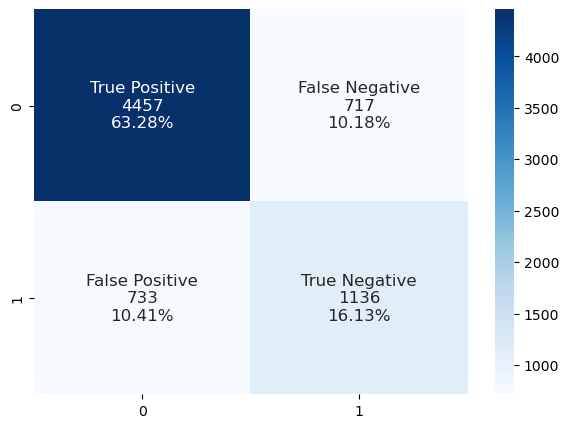

In [59]:
group_names = ["True Positive", "False Negative", "False Positive", "True Negative"]
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

plt.figure(figsize=(7, 5))
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues', annot_kws={"fontsize":12})
plt.savefig('cm', dpi=500)

In [60]:
tp, fn, fp, tn = cf_matrix.flatten()

## Feature Simulation

In [61]:
simulation_features = ['Tenure Months', 'Device Class', 'Payment Method_Pulsa', 'Games Product']

In [84]:
# Create Simulation Function
def simulation(feature, sample_percentage):
    # Define TP FN FP TN var
    tp, fn, fp, tn = cf_matrix.flatten()

    # Create Simulation Data
    df_churn = df_final[df_final['Churn Label'] == 1]
    df_not_churn = df_final[df_final['Churn Label'] == 0]

    cr_list = []

    # Create Improvement Experiments
    experiments = np.arange(-1,1.05,0.05)
    experiments[20] = 0
    for i in experiments:
        # Take sample for experiment dataset churn and not churn n% each.
        df_simulation = (pd.concat([df_churn.sample(int(np.ceil(sample_percentage*df_churn.shape[0])), random_state=42)
                                    ,df_not_churn.sample(int(np.ceil(sample_percentage*df_not_churn.shape[0])), random_state=42)])
                         .reset_index(drop=True))
        # Increase or decrease the variable of intereset (simulation feature).
        df_simulation[feature] = df_simulation[feature]*(1+i)
        
        # Replace 0 Value to Small Value
        for i in simulation_features:
            # Replace with minimum value that isnt zero and divide by 10
            df_simulation[i].replace(0, (df_final[df_final[i] > 0][i].min())/10, inplace = True)

        # Feature Scaling
        df_simulation = df_simulation[X_column_order]
        df_simulation = scaler.transform(df_simulation)
        df_simulation = pd.DataFrame(df_simulation, columns=X_column_order)

        # Predict Simulation Values
        simulation_pred = (lgr.predict_proba(df_simulation)[:, 1] >= 0.65).astype(int)


        # Calculate Simulation Conversion Rate
        cr = simulation_pred[simulation_pred==1].size/simulation_pred.size
        cr_list.append(cr)

    # Create CR Plot
    print(f'Current Churn Rate: {cr_list[20]}')
    print(cr_list)
    plt.plot(experiments, cr_list, marker='o', linewidth=1)
    plt.ylabel('Churn Rate')
    plt.xlabel(str(feature) + ' Increased')
    plt.title('Churn Rate by ' + str(feature))
    plt.axvline(linewidth=1, color='r', label = 'Current Condition')
    plt.legend()
    plt.show()

### Tenure Months (Nominal)

In [85]:
import warnings

Current Churn Rate: 0.26224620190259834
[0.5094419991480903, 0.5036206162146812, 0.4838847082209286, 0.46713048416867814, 0.45335794405792984, 0.44214113303989777, 0.4266647735340054, 0.40891665483458756, 0.3925883856311231, 0.3803776799659236, 0.36532727530881726, 0.3502768706517109, 0.3357944057929859, 0.3250035496237399, 0.3115149794121823, 0.3005821382933409, 0.291921056368025, 0.28382791424109044, 0.2757347721141559, 0.2680675848360074, 0.26224620190259834, 0.2552889393724265, 0.24875763169104076, 0.24307823370722703, 0.23739883572341333, 0.23413318188272042, 0.2297316484452648, 0.22547209995740453, 0.22107056651994889, 0.2168110180320886, 0.21198352974584694, 0.20800795115717735, 0.20403237256850773, 0.19934686923186143, 0.1966491551895499, 0.19309953144966632, 0.1902598324577595, 0.18742013346585262, 0.18500638932273178, 0.18259264517961096, 0.1810308107340622]


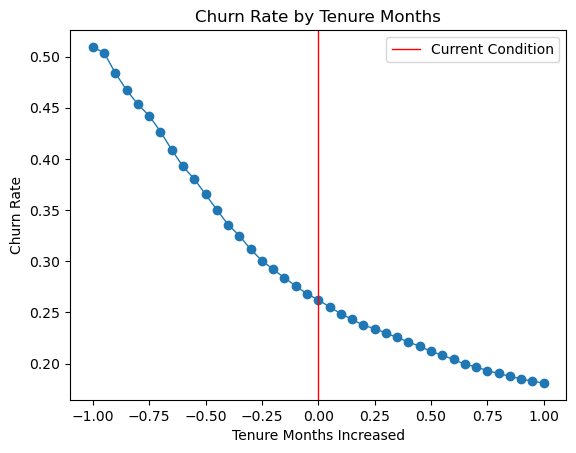

In [86]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    simulation('Tenure Months', 1)

In [83]:
# 15% increased
(0.26224620190259834-0.24307823370722703)*100

1.916796819537131

If we increased tenure months by 15% churn rate is decreased by 0.6%

### Device Class (Ordinal)

Since manipulating customers device class is not realistic, we're not conducting experiments for this one. But we can stil conduct further analysis for this one.

### Payment Method_Pulsa (Binary from Ordinal)

This experiment can be conducted by increase or decrease the number of those who use pulsa as a payment method.

We can see that there are 33.5 % of those who use pulsa as payment method. Decreasing this number would lead to decrease in the churn rate of our customers.

Example:
Current Customers who use pulsa = 1000

Scenario Increase
- 15% increase = 1000 + 1000*0.15 = 1000 + 150 = 1150.
- Set 150 non pulsa to pulsa.

======================================

- 95% decrease = 1000 + 1000*-0.95 = 1000 + (-950) = 50.
- set 950 pulsa to non pulsa.

In [751]:
def simulation_binary_feature(feature, sample_percentage):
    # get churn customers
    df_churn = df_final[df_final['Churn Label'] == 1]
    # get non churn customers
    df_not_churn = df_final[df_final['Churn Label'] == 0]
    
    # create experiment improvement from 100 decrease to 100 increase.
    experiments = np.arange(-1, 1.05, 0.05)
    experiments[20] = 0
    
    # calculate current (variable of interest) rate
    curr_feature_pos = df_final[df_final[feature] == 1].shape[0]
    
    cr_list = []
    
    for experiment in experiments:
        # using n% sample
        sample_size_pos = int(np.ceil(sample_percentage*df_churn.shape[0]))
        sample_size_neg = int(np.ceil(sample_percentage*df_not_churn.shape[0]))
        df_simulation = (pd.concat([df_churn.sample(sample_size_pos, random_state=42),
                                   df_not_churn.sample(sample_size_neg, random_state=42)
                                   ]))
        
        # Apply experiment
        # get feature positive and negative
        df_feature_pos = df_simulation[df_simulation[feature] == 1]
        df_feature_neg = df_simulation[df_simulation[feature] == 0]
        # calculate the change (increase or decrease) on the feature of interest.
        if experiment < 0:
            # calculate the number of decrease on positive class
            decrease_number = np.ceil(abs(curr_feature_pos*experiment))
            # set positive class (1) to negative class (0)
            df_feature_pos.iloc[:int(decrease_number), df_feature_pos.columns.get_loc(feature)] = 0
        elif experiment > 0:
            # calculate the number of increase on positive class
            increase_number = np.ceil(curr_feature_pos*experiment)
            # set negative class (0) to positive (1)
            df_feature_neg.iloc[:int(increase_number), df_feature_neg.columns.get_loc(feature)] = 1
        
        # Save the experiment
        df_simulation = pd.concat([df_feature_pos, df_feature_neg], axis=0)
        df_simulation = scaler.transform(df_simulation[X_column_order])
        df_simulation = pd.DataFrame(df_simulation, columns=X_column_order)

        # Predict Simulation Values
        simulation_pred = (lgr.predict_proba(df_simulation)[:, 1] >= 0.65).astype(int)
        
        # Calculate Simulation Conversion Rate
        cr = simulation_pred[simulation_pred==1].size/simulation_pred.size
        cr_list.append(cr)
    
    # Create CR Plot
    print(f'Current Churn Rate: {cr_list[20]}')
    print(cr_list)
    plt.plot(experiments, cr_list, marker='o', linewidth=1)
    plt.ylabel('Churn Rate')
    plt.xlabel(str(feature) + ' Increased')
    plt.title('Churn Rate by ' + str(feature))
    plt.axvline(linewidth=1, color='r', label = 'Current Condition')
    plt.legend()
    plt.show()

Current Churn Rate: 0.2630981116001704
[0.20133465852619623, 0.2031804628709357, 0.2065881016612239, 0.20942780065313077, 0.21155757489706092, 0.21496521368734914, 0.217804912679256, 0.22036064177197218, 0.22305835581428368, 0.2267499645037626, 0.22958966349566945, 0.2324293624875763, 0.23583700127786456, 0.23910265511855744, 0.24350418855601305, 0.2466278574471106, 0.25074542098537556, 0.2537271049268778, 0.2568507738179753, 0.2598324577594775, 0.2630981116001704, 0.26622178049126793, 0.2701973590799375, 0.27317904302143975, 0.27758057645889533, 0.2809882152491836, 0.2843958540394718, 0.2876615078801647, 0.28922334232571345, 0.2903592219224762, 0.291921056368025, 0.2937668607127644, 0.2944767854607412, 0.29547068010790856, 0.2963225898054806, 0.29745846940224335, 0.29944625869657815, 0.30086610819253157, 0.30242794263808037, 0.30342183728524774, 0.30469970183160583]


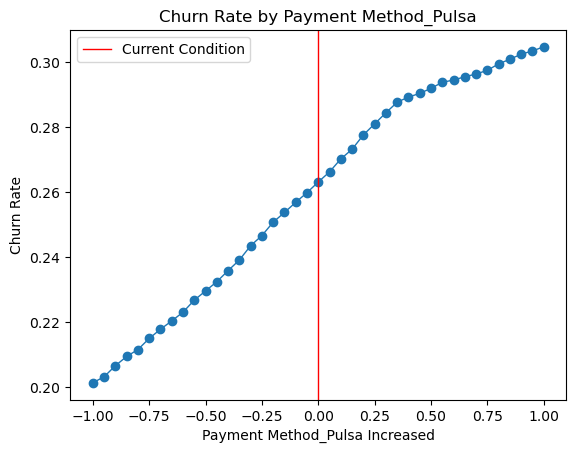

In [752]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    simulation_binary_feature('Payment Method_Pulsa', 1)

In [637]:
# 10% decrease
abs(0.2653698707936959-0.2700553741303422)*100

0.46855033366463017

### Games Product (Binary)

Current Churn Rate: 0.2653698707936959
[0.2734630129206304, 0.27261110322305837, 0.27246911827346304, 0.272043163424677, 0.272043163424677, 0.2713332386767003, 0.27104926877750957, 0.2707652988783189, 0.2704813289791282, 0.27033934402953286, 0.2701973590799375, 0.2700553741303422, 0.26962941928155615, 0.26906147948317477, 0.2692034644327701, 0.2684935396847934, 0.26820956978560273, 0.267925599886412, 0.267499645037626, 0.2665057503904586, 0.2653698707936959, 0.26437597614652847, 0.2632400965497657, 0.26224620190259834, 0.26153627715462163, 0.26068436745704954, 0.25969047280988217, 0.2585545932131194, 0.257560698565952, 0.2564248189691893, 0.2557148942212126, 0.2548629845236405, 0.25401107482606844, 0.25273321027971035, 0.2515973306829476, 0.2506034360357802, 0.2496095413886128, 0.24904160159023145, 0.2483316768422547, 0.24818969189265938, 0.24776373704387336]


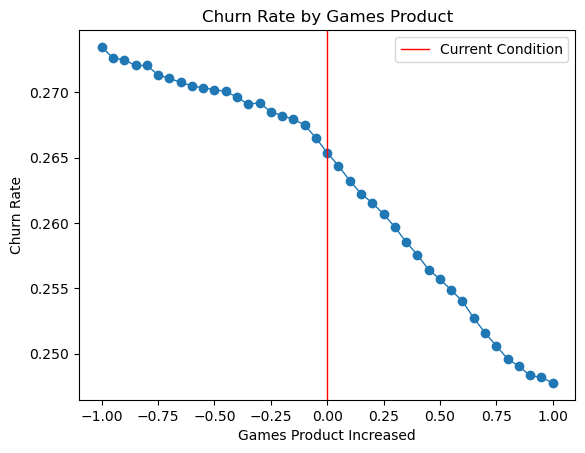

In [638]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    simulation_binary_feature('Games Product', 1)

In [639]:
# Increase by 10%
(0.2653698707936959-0.2632400965497657)*100

0.21297742439301826

### Call Center (Binary)

Current Churn Rate: 0.2653698707936959
[0.2734630129206304, 0.27289507312224903, 0.27246911827346304, 0.272043163424677, 0.27161720857589094, 0.2713332386767003, 0.27119125372710495, 0.2706233139287236, 0.27033934402953286, 0.2700553741303422, 0.26962941928155615, 0.26962941928155615, 0.26906147948317477, 0.2686355246343888, 0.2684935396847934, 0.26820956978560273, 0.2677836149368167, 0.26764162998722135, 0.2667897202896493, 0.26622178049126793, 0.2653698707936959, 0.26437597614652847, 0.26352406644895643, 0.262530171801789, 0.2619622320034076, 0.2611103223058356, 0.26025841260826355, 0.25954848786028684, 0.2585545932131194, 0.257560698565952, 0.25670878886837994, 0.25543092432202186, 0.2545790146244498, 0.25330115007809173, 0.2524492403805197, 0.25131336078375693, 0.2506034360357802, 0.24975152633820816, 0.2496095413886128, 0.2493255714894221, 0.24875763169104076]


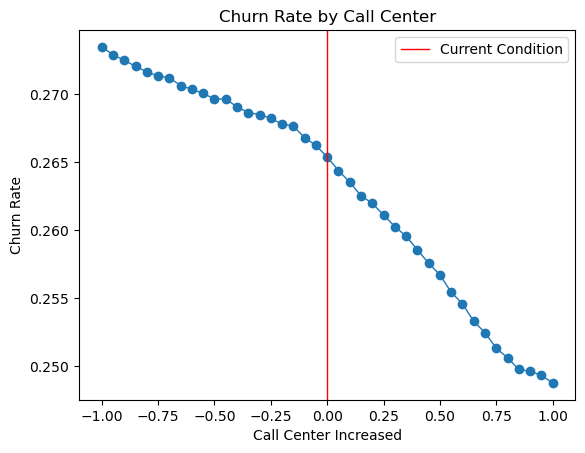

In [746]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    simulation_binary_feature('Call Center', 1)

## Apply Recommendations Simulation

In [674]:
def binary_simulation(feature, improvement):
    df_feature_pos = df_simulation[df_simulation[feature] == 1]
    df_feature_neg = df_simulation[df_simulation[feature] == 0]
 
    # increase point
    if improvement > 0:
        # calculate feature negative class
        curr_neg = df_simulation[df_simulation[feature] == 0].shape[0]
        # calculate number of observations by 10% increased
        increased_number = np.ceil(curr_neg*improvement)
        # randomly select n number of dataset and set the value from 0 to 1
        df_feature_sample_neg = df_feature_neg.sample(n=int(increased_number), random_state=42)
        df_feature_sample_neg[feature] = 1
        # apply change on sample to the population of positive class
        df_feature_neg.loc[df_feature_sample_neg.index] = df_feature_sample_neg
        
        return pd.concat([df_feature_pos, df_feature_neg], axis=0)
    
    # decrease point
    elif improvement < 0:
        # calculate feature positive class
        curr_pos = df_simulation[df_simulation[feature] == 1].shape[0]
        # calculate number of observations by 10% decreased
        decreased_number = np.ceil(abs(curr_pos*improvement))
        # randomly select n number of dataset and set the value from 1 to 0
        df_feature_sample_pos = df_feature_pos.sample(n=int(decreased_number), random_state=42)
        df_feature_sample_pos[feature] = 0
        # apply change on sample to the population of positive class
        df_feature_pos.loc[df_feature_sample_pos.index] = df_feature_sample_pos
        
        return pd.concat([df_feature_pos, df_feature_neg], axis=0)

In [761]:
init_cr = (df_final[df_final['Churn Label'] == 1].shape[0]/df_final.shape[0])*100
print(f'Initial Churn Rate = {init_cr:.2f}%')

# Define TP FN FP TN var
tp, fn, fp, tn = cf_matrix.flatten()

# Create Simulation Data
df_churn = df_final[df_final['Churn Label'] == 1]
df_not_churn = df_final[df_final['Churn Label'] == 0]

# Create Improvement Experiments
df_simulation = pd.concat([df_churn, df_not_churn], axis=0)

# 1. Increased Tenure Months by 20%
df_simulation['Tenure Months'] = df_simulation['Tenure Months']*1.20
#Replace 0 with small value
(df_simulation['Tenure Months'].replace({0, 
        df_simulation[df_simulation['Tenure Months']> 0]['Tenure Months'].min()/10}, inplace=True))

# 2. Decreased Payment Method_Pulsa by 15%
df_simulation = binary_simulation('Payment Method_Pulsa', -0.15)

# 3. Increased Games Product by 15%
df_simulation = binary_simulation('Games Product', 0.15)

# 4. Increased Call Center by 15%
df_simulation = binary_simulation('Call Center', 0.15)

# Feature Scaling
df_simulation = scaler.transform(df_simulation[X_column_order])
df_simulation = pd.DataFrame(df_simulation, columns=X_column_order)

# Predict Simulation Values
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    simulation_pred = (lgr.predict_proba(df_simulation)[:, 1] >= 0.65).astype(int)
    #simulation_pred = lgr.predict(df_simulation)

cr = (simulation_pred[simulation_pred==1].shape[0]/simulation_pred.shape[0])*100
print(f'Churn Rate After All Recommendations = {cr:.2f}%')

Initial Churn Rate = 26.54%
Churn Rate After All Recommendations = 21.18%


In [757]:
26.54-21.18

5.359999999999999

## Sensitivity Analysis

### Payment Pulsa

In [645]:
predict_row = np.array([[2, 4210.7, 2, 2, 0, 1, 1, 1, 0, 1, 0, 0]])
predict_scaled = scaler.transform(predict_row)
lgr.predict_proba(predict_scaled)[:, 1]

C:\Users\ASUS\anaconda3\envs\loan_prediction_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


array([0.8917446])

### Payment Not Pulsa

In [646]:
predict_row = np.array([[2, 4210.7, 2, 2, 0, 1, 0, 1, 0, 1, 0, 0]])
predict_scaled = scaler.transform(predict_row)
lgr.predict_proba(predict_scaled)[:, 1]

C:\Users\ASUS\anaconda3\envs\loan_prediction_env\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


array([0.82010876])